

*  **데이터 전처리**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
%matplotlib inline

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/vgames2.csv')
# 결측치 확인
df.isnull().sum()

In [3]:
# 데이터 불러오기
df = pd.read_csv('/content/vgames2.csv')
# 결측치 제거
df.isnull().sum()
# 결측치/전체데이터% = 약 2.5% -> 제거하기로 결정
df = df.dropna()
df = df.drop('Unnamed: 0', axis=1)

In [4]:
# 각 feature의 단위 제거 및 변환
# 각 열에서 K있는 행만 추출 -> K 제거 후 /1000 -> 해당 열의 K있는 행이 제거된 df 와 concat
# 위 과정을 각 컬럼별로 반복 시행

drop1 = df[['EU_Sales', 'JP_Sales', 'Other_Sales']]
df_K1 = df.drop(drop1, axis=1)
df_K11 = df_K1[~df_K1['NA_Sales'].str.contains('K')]
df_K1 = df_K1[df_K1['NA_Sales'].str.contains('K')]
df_K1['NA_Sales'] = df_K1['NA_Sales'].str.replace('K', '').astype('float')/1000
df1 = pd.concat([df_K11,df_K1])

drop2 = df[['NA_Sales', 'JP_Sales', 'Other_Sales']]
df_K2 = df.drop(drop2, axis=1)
df_K21 = df_K2[~df_K2['EU_Sales'].str.contains('K')]
df_K2 = df_K2[df_K2['EU_Sales'].str.contains('K')]
df_K2['EU_Sales'] = df_K2['EU_Sales'].str.replace('K', '').astype('float')/1000
df2 = pd.concat([df_K21,df_K2])

drop3 = df[['NA_Sales', 'EU_Sales', 'Other_Sales']]
df_K3 = df.drop(drop3, axis=1)
df_K31 = df_K3[~df_K3['JP_Sales'].str.contains('K')]
df_K3 = df_K3[df_K3['JP_Sales'].str.contains('K')]
df_K3['JP_Sales'] = df_K3['JP_Sales'].str.replace('K', '').astype('float')/1000
df3 = pd.concat([df_K31,df_K3])

drop4 = df[['NA_Sales', 'EU_Sales', 'JP_Sales']]
df_K4 = df.drop(drop4, axis=1)
df_K41 = df_K4[~df_K4['Other_Sales'].str.contains('K')]
df_K4 = df_K4[df_K4['Other_Sales'].str.contains('K')]
df_K4['Other_Sales'] = df_K4['Other_Sales'].str.replace('K', '').astype('float')/1000
df4 = pd.concat([df_K41,df_K4])

# 시행된 데이터들 합치기
df = pd.merge(df1, df2)
df = pd.merge(df, df3)
df = pd.merge(df, df4)

In [5]:
# M 삭제 및 float 타입으로 변경
cols = df.columns[5:9]
for col in cols:
  df[col] = df[col].astype('string').str.replace('M','').astype('float')

In [126]:
# Year 컬럼 표현방식 통합
# 2자리 숫자이므로 30 업다운으로 19년도와 20년도 게임 구분 -> 각각 1900과 2000 더한 후 데이터 합치기

def Y(x):
  if (x >= 0) & (x <= 30):
    return int(2000 + x)
  elif (30 <= x) & (x <= 100):
    return int(1900 + x)
  else:
    return int(x)

df['Year'] = df['Year'].apply(Y)

# 총 판매량 컬럼 생성
df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


**데이터 분석**



> *   필수 포함 내용

**1.   지역에 따라서 선호하는 게임 장르가 다를까**


```
# 1.1 장르별 총 판매량 (지역별로)
# 1.2 지역별 인기 장르
# 1.3 지역별 총 판매량
```


**2.   연도별 게임의 트렌드가 있을까**


```
# 2.1 연도별 최다 출시횟수의 장르 (2000년대)
# 2.2 연도별 최고 판매량의 장르 (2000년대)
```


**3.   출고량이 높은 게임에 대한 분석 및 시각화 프로세스**


```
# 3.1 역대 판매량 TOP10 게임
# 3.2 각 장르에서 판매량 TOP10 게임
# 3.3 판매량 높은 게임 중 1택 
```








In [128]:
# 장르/지역별 판매량 합산
genre = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales' ]]
df_11 = genre.groupby(['Genre']).sum().reset_index()
df_11.columns = ['Genre', 'NA', 'EU', 'JP', 'Other']
# 장르/판매국/판매량
df_11m = pd.melt(df_11, id_vars=['Genre'], value_vars=df_11.columns[1:], 
                 var_name='Continents', value_name='Sales')
df_11m.head()

,Genre,Continents,Sales
0,Action,NA,858.75
1,Adventure,NA,101.79
2,Fighting,NA,220.35
3,Misc,NA,394.73
4,Platform,NA,445.38


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'Sales by Genre (Continents)')

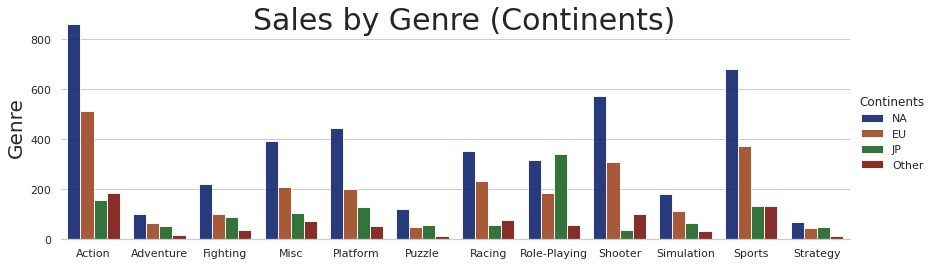

In [27]:
# 장르별 총 판매량 (지역)

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_11m, kind="bar",
    x="Genre", y="Sales", hue="Continents",
    ci="sd", palette="dark", alpha=0.9, size=4, aspect=3
)
g.despine(left=True)
g.set_axis_labels("", "Genre", fontsize=20)
g.legend.set_title("Continents")
g.fig.suptitle('Sales by Genre (Continents)', fontsize=30)

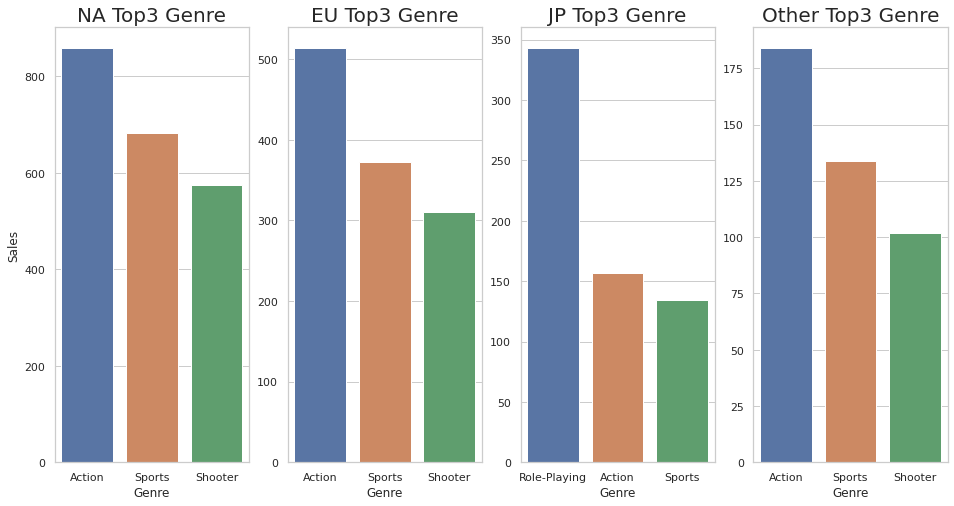

In [31]:
# 지역별 인기 장르
df_12 = df_11m.sort_values('Sales', ascending=False)
df_12_NA = df_12[df_12['Continents'].isin(['NA'])].head(3)
df_12_EU = df_12[df_12['Continents'].isin(['EU'])].head(3)
df_12_JP = df_12[df_12['Continents'].isin(['JP'])].head(3)
df_12_Other = df_12[df_12['Continents'].isin(['Other'])].head(3)

sns.set_style('whitegrid')
fig = plt.figure(figsize=(16,8))
area1 = fig.add_subplot(1,4,1)
area1.set_title('NA Top3 Genre', fontsize=20)
area2 = fig.add_subplot(1,4,2)
area2.set_title('EU Top3 Genre', fontsize=20)
area3 = fig.add_subplot(1,4,3)
area3.set_title('JP Top3 Genre', fontsize=20)
area4 = fig.add_subplot(1,4,4)
area4.set_title('Other Top3 Genre', fontsize=20)
sns.barplot(x='Genre', y='Sales', data=df_12_NA, ax=area1)
sns.barplot(x='Genre', y='Sales', data=df_12_EU, ax=area2)
area2.set_ylabel('')
sns.barplot(x='Genre', y='Sales', data=df_12_JP, ax=area3)
area3.set_ylabel('')
sns.barplot(x='Genre', y='Sales', data=df_12_Other, ax=area4)
area4.set_ylabel('')

plt.show()

Text(0.5, 1.0, 'Total Sales by Continents')

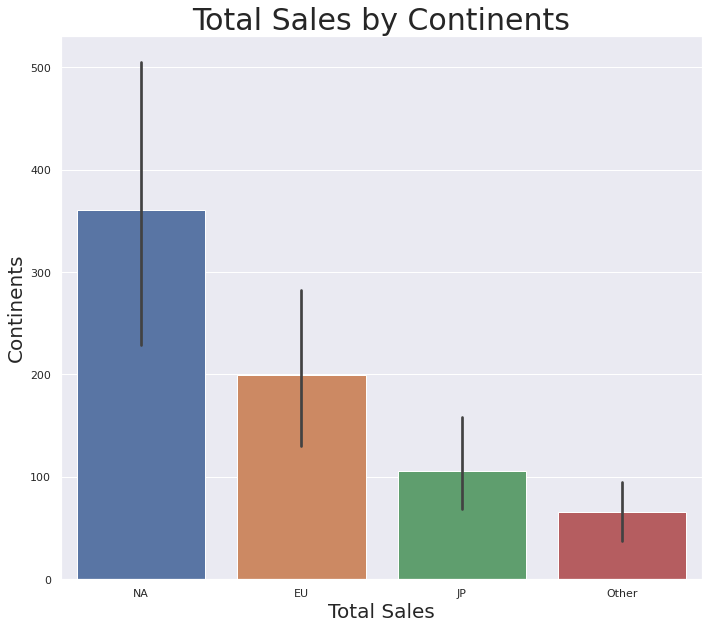

In [16]:
# 지역별 총 판매량 비교
sns.set(rc = {'figure.figsize':(11.5,10)})
a1 = sns.barplot(data = df_11m, x='Continents', y='Sales')
plt.xlabel("Total Sales", fontsize=20)
plt.ylabel("Continents", fontsize=20)
a1.set_title('Total Sales by Continents', fontsize=30)

Text(0.5, 1.0, 'Most Published Genre by Year')

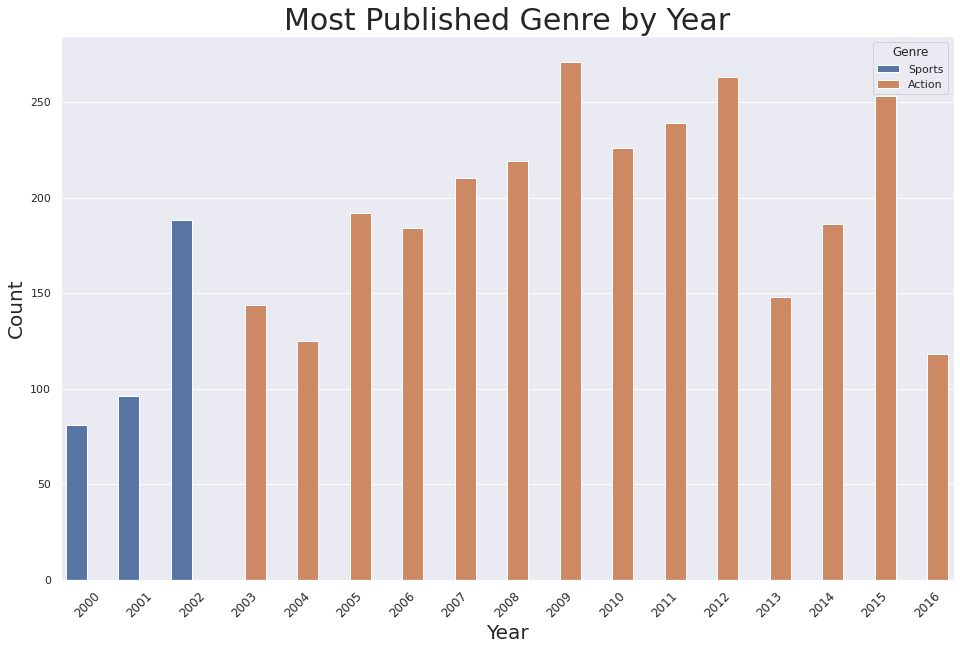

In [123]:
# 연도별 최다 출시횟수의 장르
df_ysalesc = df.groupby(by=['Year', 'Genre']).size().reset_index(name='count') # 연도별 각 장르의 갯수
ysalesc = df_ysalesc.groupby(by=['Year'])['count'].transform(max) == df_ysalesc['count'] # 연도 중 가장 큰 값
ysalesc = df_ysalesc[ysalesc].reset_index(drop=True).drop_duplicates(subset=['Year'], keep='last').reset_index()
ysalesc = ysalesc[(ysalesc.Year <= 2016)]
ysalesc_00up = ysalesc[(ysalesc.Year >= 2000)]
ysalesc_12up = ysalesc[(ysalesc.Year >= 2012)]

sns.set(rc = {'figure.figsize':(16,10)})
a1 = sns.barplot(data = ysalesc_00up, x='Year', y='count', hue='Genre')
plt.xlabel("Year", fontsize=20)
plt.xticks(fontsize=12,rotation=45)
plt.ylabel("Count", fontsize=20)
a1.set_title('Most Published Genre by Year', fontsize=30)

Text(0.5, 1.0, 'Most Saled Genre by Year')

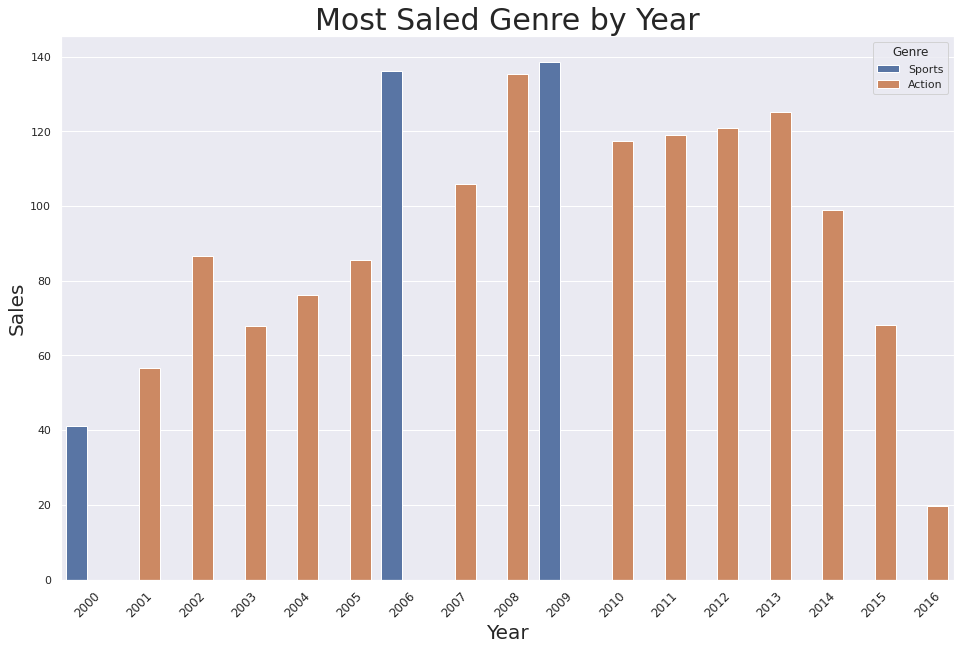

In [121]:
# 연도별 최고 판매량의 장르
df_ysales = df.groupby(by=['Year', 'Genre'])['Total_Sales'].sum().reset_index() # 연도별 각 장르의 총 판매량
ysales = df_ysales.groupby(by=['Year'])['Total_Sales'].transform(max) == df_ysales['Total_Sales'] # 연도 중 가장 큰 값
ysales = df_ysales[ysales].reset_index(drop=True).drop_duplicates(subset=['Year'], keep='last').reset_index() 
ysales = ysales[(ysales.Year <= 2016)]
ysales_00up = ysales[(ysales.Year >= 2000)]
ysales_12up = ysales[(ysales.Year >= 2012)]

sns.set(rc = {'figure.figsize':(16,10)})
a1 = sns.barplot(data = ysales_00up, x='Year', y='Total_Sales', hue='Genre')
plt.xlabel("Year", fontsize=20)
plt.xticks(fontsize=12,rotation=45)
plt.ylabel("Sales", fontsize=20)
a1.set_title('Most Saled Genre by Year', fontsize=30)

Text(0.5, 1.0, 'Most Saled Top 10 Game (07~)')

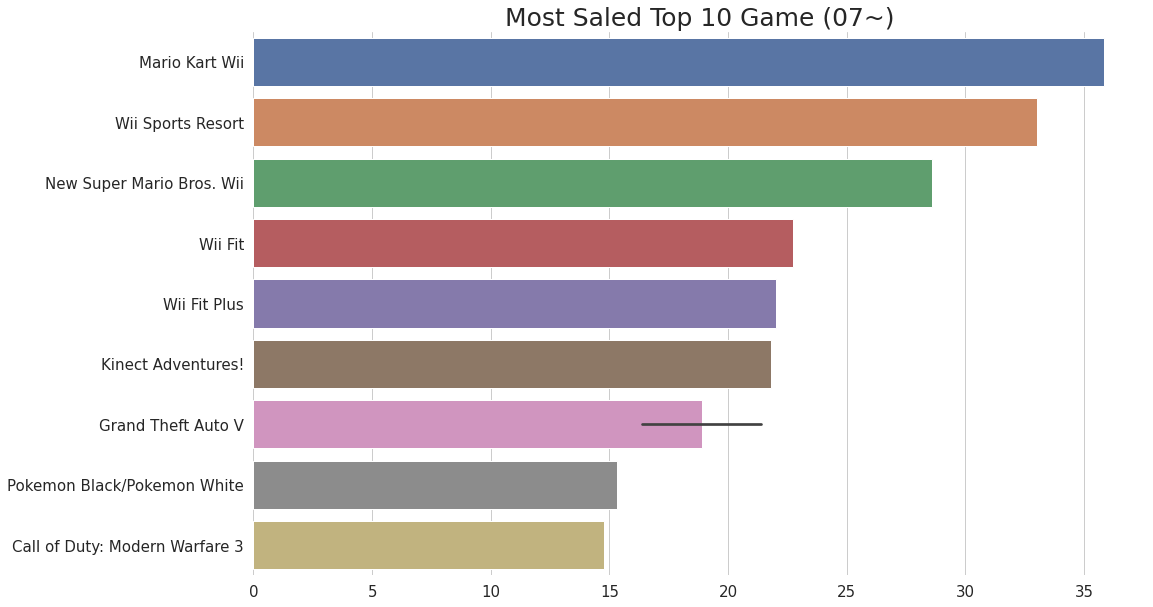

In [170]:
# 역대 판매량 TOP10 게임
df07 = df[(df.Year >= 2007)]
df07 = df07[(df07.Year <= 2016)]
sales_top10 = df07.loc[df07.Total_Sales.sort_values(ascending=False).index].head(10).reset_index(drop=True)

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 10))
a1 = sns.barplot(x="Total_Sales", y="Name", data=sales_top10)
ax.set(ylabel="", xlabel="")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine(left=True, bottom=True)
a1.set_title('Most Saled Top 10 Game (07~)', fontsize=25)

In [171]:
sales_top10

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
1,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
2,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
3,Wii Fit,Wii,2007,Sports,Nintendo,8.94,8.03,3.60,2.15,22.72
4,Wii Fit Plus,Wii,2009,Sports,Nintendo,9.09,8.59,2.53,1.79,22.00
5,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
6,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
7,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
8,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5.57,3.28,5.65,0.82,15.32
9,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76


In [ ]:
# 각 장르에서 판매량 TOP10


In [ ]:
# 역대 판매량 1등 게임
